In [12]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple
from model2D import *
#from model3D import *
from model3D_small import *
import math
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils  import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import offsetbox
from tensorflow.keras.applications.resnet50 import ResNet50
import visualkeras
from keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
from sklearn.manifold import TSNE
from PIL import Image
from matplotlib.patches import Patch
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
train_videoes = "data/train_sample_videos"
test_videos = "data/test_videos"

print(f"Train Videoes: {len(os.listdir(train_videoes))}\nTest Vidoes: {len(os.listdir(test_videos))}")

Train Videoes: 401
Test Vidoes: 400


In [3]:
meta_data = pd.read_json(train_videoes+"/metadata.json").T
labels_col =meta_data["label"].to_list()
paths_col = meta_data.index.to_list()
print(meta_data.head())

               label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4


In [4]:
def get_faces(paths: list, face_amount: int) -> (np.ndarray, list):
    video_array = []
    invalid_indices = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for idx, path in enumerate(tqdm(paths)):
        vc = cv2.VideoCapture(path)

        faces = []
        while len(faces) < face_amount:
            ret, frame = vc.read()
            if ret and frame is not None:    
                #gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                face = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=7,minSize=(109,109))
                if len(face) > 0:
                    x, y, w, h = max(face, key=lambda x: x[2] * x[3])
                    face_img = frame[y:y+h, x:x+w]
                    face_img = cv2.resize(face_img, (224, 224))
                    faces.append(face_img)
            else:
                break
        vc.release()
        if len(faces) == face_amount:
            video_array.append(np.array(faces))
        else:
            invalid_indices.append(idx)

    
    
    return np.array(video_array), invalid_indices

In [7]:
training_videos_sample = os.listdir(train_videoes)
sample_file_names = training_videos_sample.copy()
complete_paths = []

for path in paths_col:
    complete_paths.append(train_videoes+"/"+path)
complete_paths.sort()

(faces, indices) = get_faces(complete_paths, 5)

100%|██████████| 400/400 [03:27<00:00,  1.93it/s]


In [31]:
y = [0 if val!="FAKE" else 1 for val in labels_col ]
y =np.array(y)
y = np.delete(y, indices)
y = to_categorical(y, num_classes=None).astype(int)

In [32]:
num_videos, num_frames, face_width, face_height, num_channels = faces.shape
flattened_size = face_width * face_height * num_channels
# Reshape the faces array to a 2D array
faces_reshaped = faces.reshape(num_videos * num_frames, flattened_size)
tsne = TSNE(n_components=2, random_state=42,perplexity=25)
faces_embedded = tsne.fit_transform(faces_reshaped)

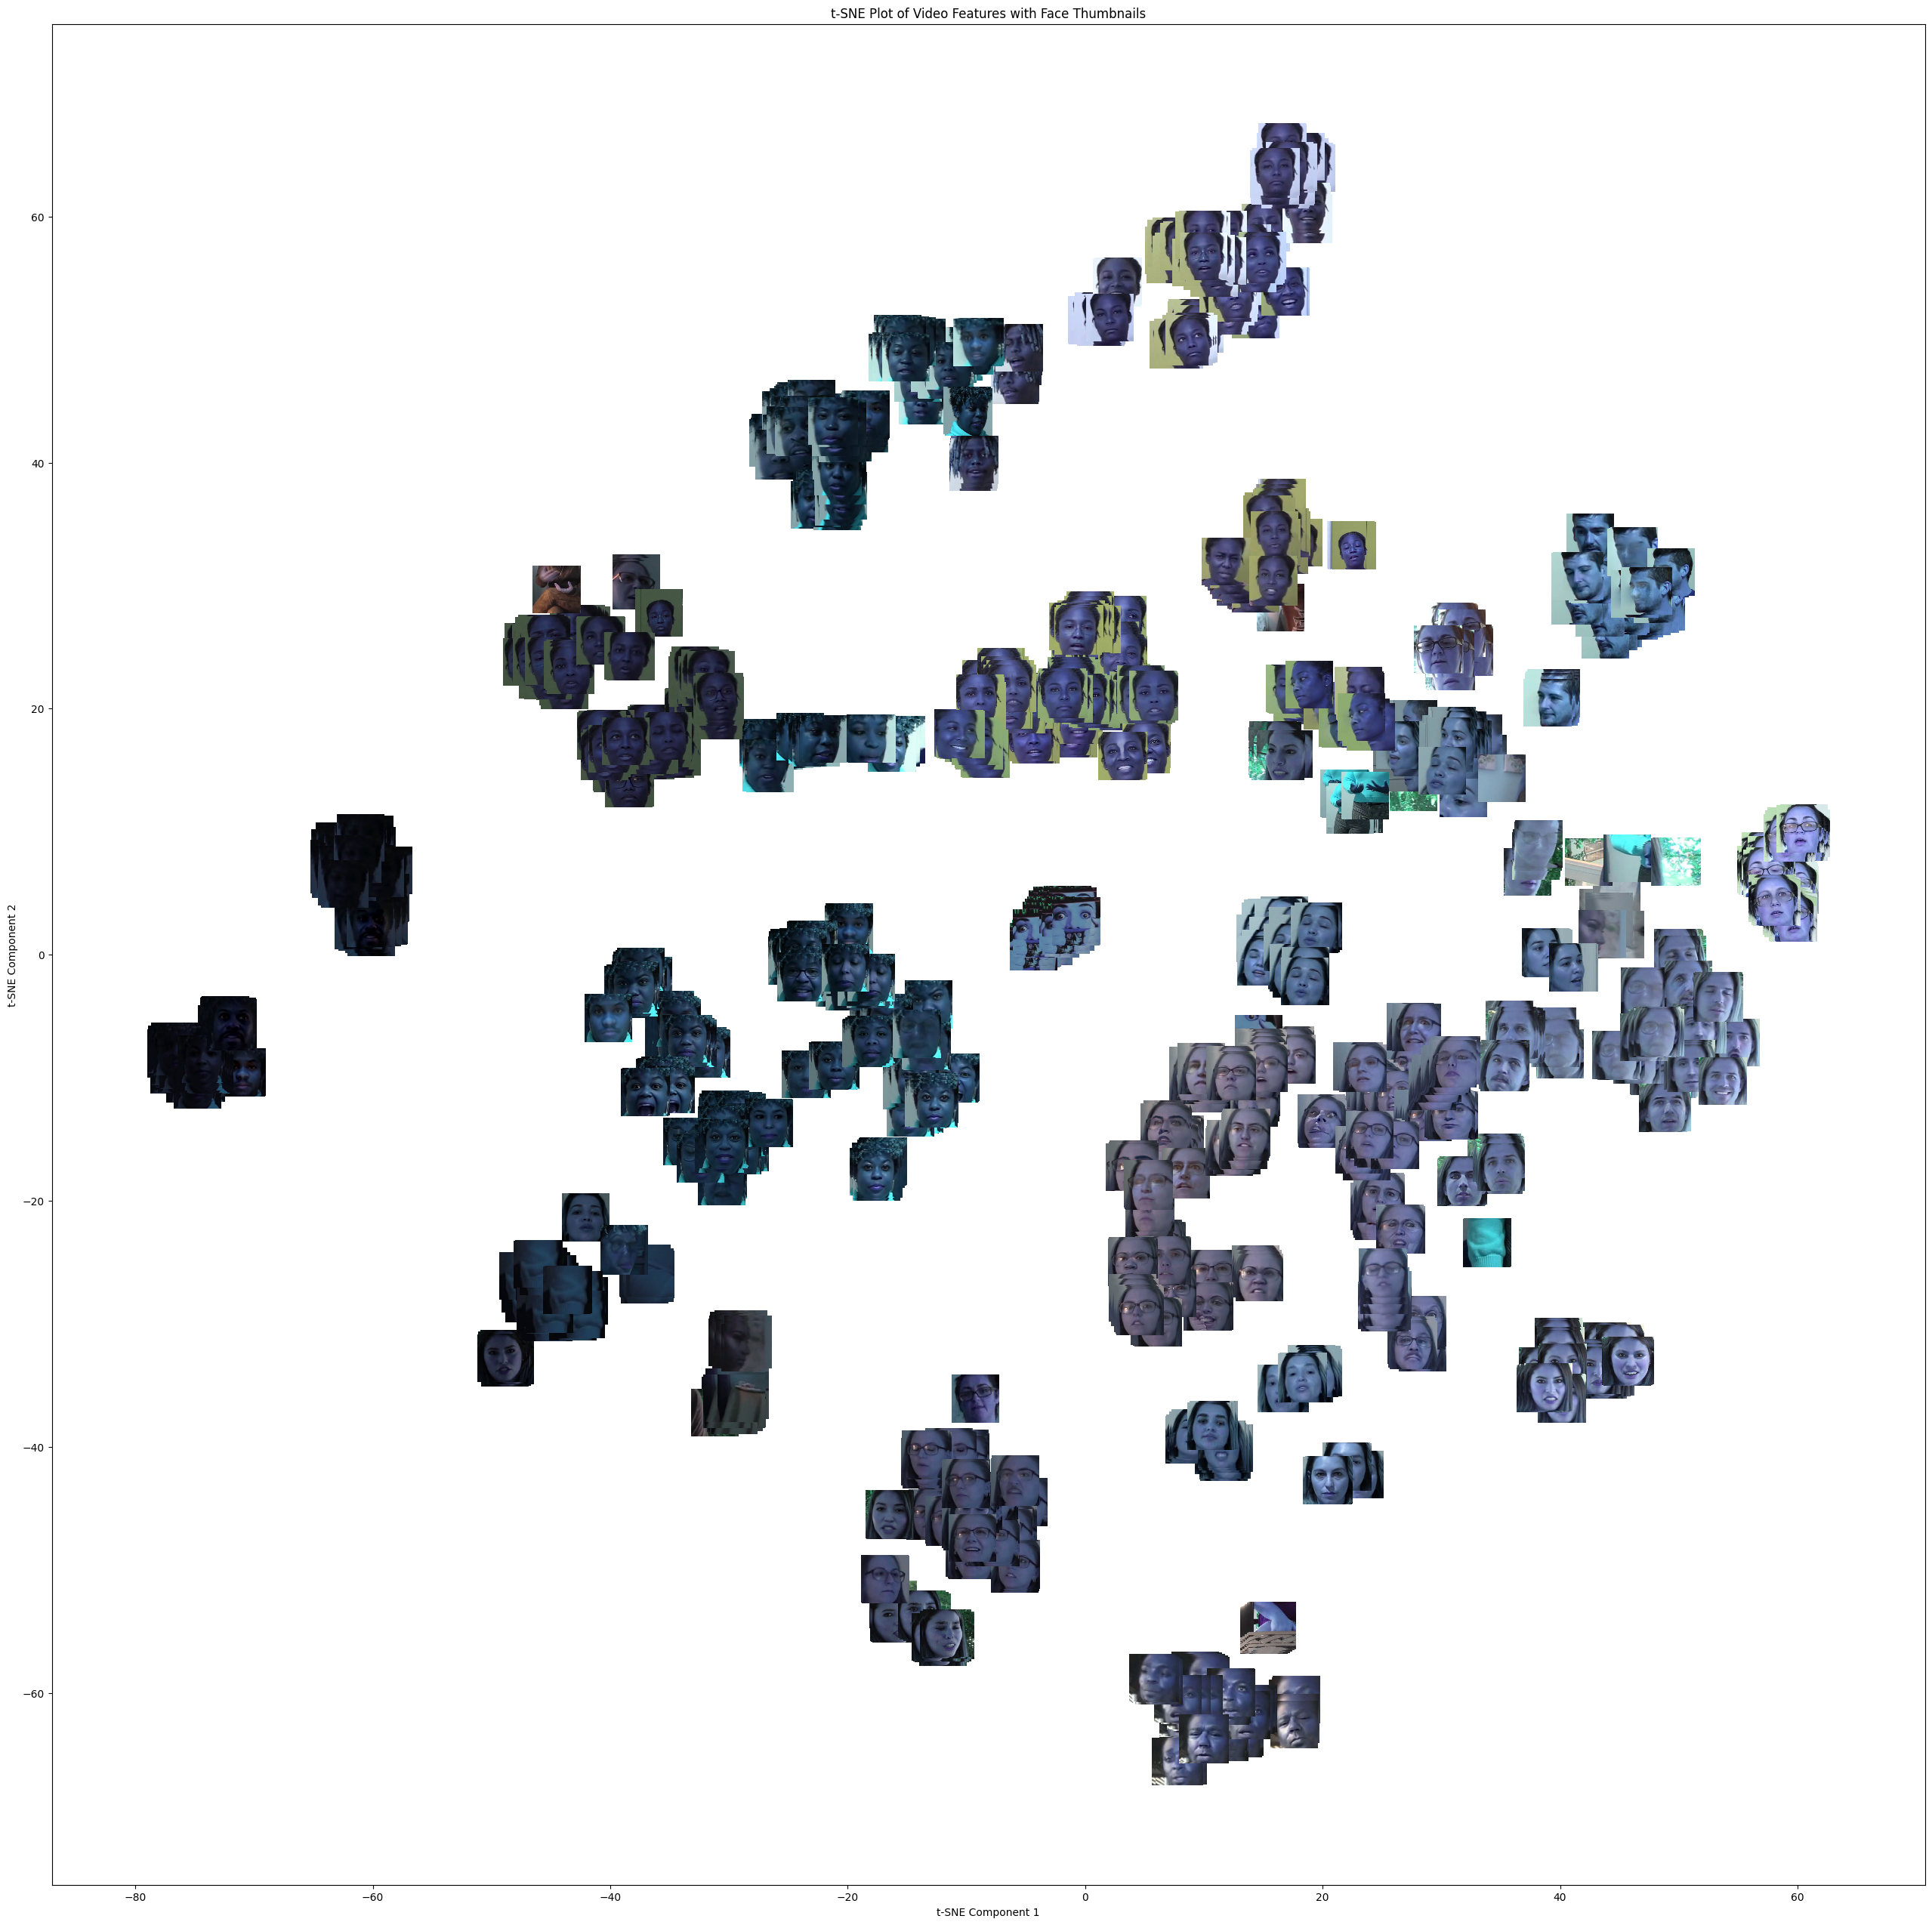

In [33]:
def plot_tsne_with_images(tsne_results, face_regions, figsize=(32, 32), thumbnail_size=(64, 36)):
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(tsne_results.shape[0]):
        x, y = tsne_results[i, :]

        img = face_regions[i]

        img_box = offsetbox.OffsetImage(img, zoom=0.2)
        img_annotation = offsetbox.AnnotationBbox(img_box, (x, y), xycoords='data', frameon=False)

        ax.add_artist(img_annotation)

    ax.set_xlim(tsne_results[:, 0].min() - 10, tsne_results[:, 0].max() + 10)
    ax.set_ylim(tsne_results[:, 1].min() - 10, tsne_results[:, 1].max() + 10)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title('t-SNE Plot of Video Features with Face Thumbnails')
    plt.show()

plot_tsne_with_images(faces_embedded, faces.reshape(num_videos * num_frames, face_width, face_height, num_channels))

In [34]:
faces_2d = faces[:,0,:,:,:]

In [35]:
train_size = 0.7
X = faces_2d    # dataset of faces
Y = y           # labels

X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=train_size)

test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(261, 224, 224, 3) (261, 2)
(80, 224, 224, 3) (80, 2)
(33, 224, 224, 3) (33, 2)


In [48]:
from keras.layers import GlobalAveragePooling2D, Dense

def build_2D_model_nb(input_data):
    base_model = ResNet50(include_top=False, input_shape=input_data.shape[1:])
    
    # Adding layers for binary classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="sigmoid")(x)
    
    # Creating a new model with the additional layers
    model = keras.Model(inputs=base_model.input, outputs=x)
    
    return model
def compile_2D_model(model, lr):
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    metrics=["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [49]:
weight_class = compute_class_weight(class_weight='balanced',classes=[0,1],y=np.argmax(y, axis=1))
class_weights = dict(zip(np.unique(y), weight_class))
class_weights

model_2d = build_2D_model_nb(X_train)
learning_rate = 1e-4
compiled_model = compile_2D_model(model_2d, learning_rate)
model_2d.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [50]:
from keras.preprocessing.image import ImageDataGenerator

# Train the model using fit_generator
history = compiled_model.fit(
    X_train, 
    y_train,
    epochs=30,
    batch_size=32, 
    verbose=2,
    validation_data=(X_valid, y_valid),
)

Epoch 1/30
9/9 - 44s - loss: 0.5089 - accuracy: 0.7739 - val_loss: 0.4378 - val_accuracy: 0.9091 - 44s/epoch - 5s/step
Epoch 2/30
9/9 - 32s - loss: 0.1251 - accuracy: 0.9847 - val_loss: 0.2969 - val_accuracy: 0.9394 - 32s/epoch - 4s/step
Epoch 3/30
9/9 - 31s - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.2955 - val_accuracy: 0.9394 - 31s/epoch - 3s/step
Epoch 4/30
9/9 - 32s - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.3833 - val_accuracy: 0.9091 - 32s/epoch - 4s/step
Epoch 5/30
9/9 - 34s - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.3662 - val_accuracy: 0.9394 - 34s/epoch - 4s/step
Epoch 6/30
9/9 - 33s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.3959 - val_accuracy: 0.9394 - 33s/epoch - 4s/step
Epoch 7/30
9/9 - 32s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.4635 - val_accuracy: 0.8788 - 32s/epoch - 4s/step
Epoch 8/30
9/9 - 32s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4504 - val_accuracy: 0.9091 - 32s/epoch - 4s/step
Epoch 9/30
9/9 - 32s - loss: 0.0023 - accuracy: 

Text(0.5, 0, 'epoch')

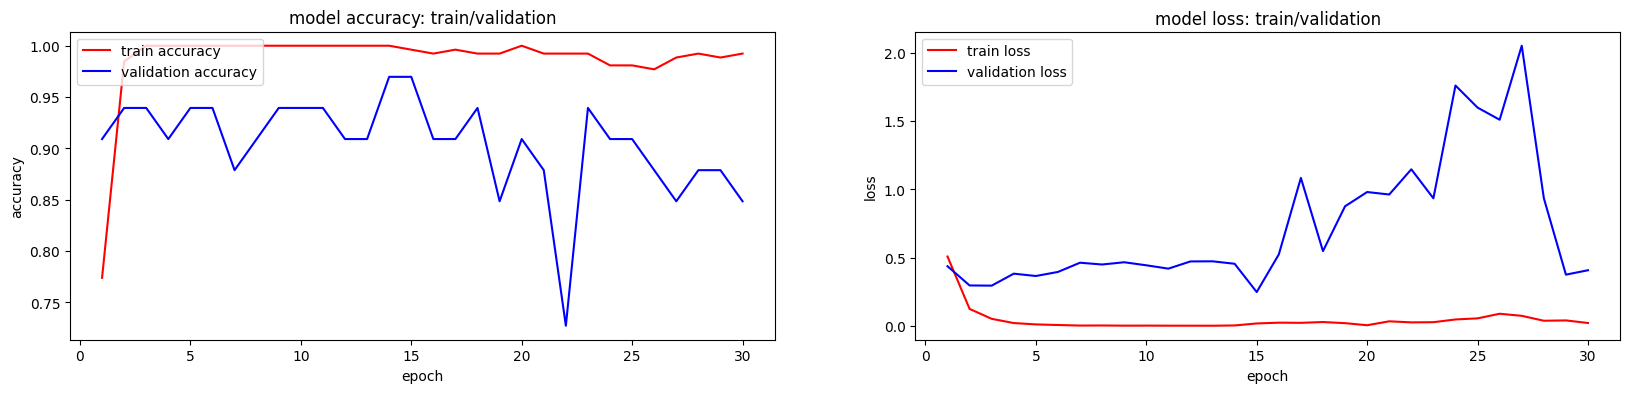

In [51]:
history_test = history
acc = history_test.history['accuracy']
val_acc = history_test.history['val_accuracy']
loss = history_test.history['loss']
val_loss = history_test.history['val_loss']
epochs = np.arange(1,len(history_test.history['accuracy'])+1)

plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title(f'model accuracy: train/validation')
plt.plot(epochs, acc, color="red", label="Training Acc")
plt.plot(epochs, val_acc, color="blue", label="Validation Acc")
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.title(f'model loss: train/validation')
plt.plot(epochs, loss, color="red", label="Loss Acc")
plt.plot(epochs, val_loss, color="blue", label="Loss Acc")
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

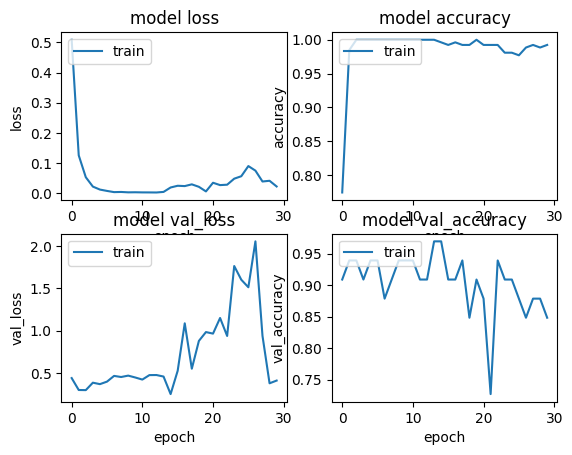

In [52]:
keys = history_test.history.keys()
for idx,key in enumerate(keys): 
    plt.subplot(2, 2, idx+1)
    plt.plot(history_test.history[key])
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

3/3 [==============================] - 3s 641ms/step
              precision    recall  f1-score   support

           0      0.571     0.222     0.320        18
           1      0.808     0.952     0.874        62

    accuracy                          0.787        80
   macro avg      0.690     0.587     0.597        80
weighted avg      0.755     0.787     0.749        80



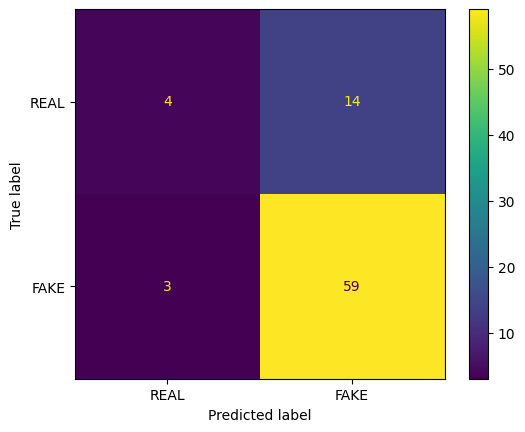

In [53]:
pred_y = compiled_model.predict(X_test)
actual_y = np.argmax(y_test, axis=1)
pred_y = np.argmax(pred_y, axis=1)
print(classification_report(actual_y, pred_y, digits=3))
cfm = confusion_matrix(actual_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels= ["REAL", "FAKE"])
disp.plot()